<a href="https://colab.research.google.com/github/larissazoraida/Diplomado-Python/blob/main/Diplomado_Ajuste_y_Extension_de_Curvas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import gspread
from gspread_dataframe import get_as_dataframe
from google.auth import default
from google.colab import auth

# Autenticacion de usuario
auth.authenticate_user()
creds, _ = default()
# Initialize gspread client
gc = gspread.authorize(creds)


In [2]:
# Conectamos a Google Drive
drive.mount('/content/gdrive')
# Establecemos el directorio de trabajo (donde se guardaran los descargables)
os.chdir('/content/gdrive/MyDrive/Datos de Colab/Proyecto de Proyeccion')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Inicio de la consulta

In [3]:
# Abrir el archivo de GoogleSheets
spreadsheet = gc.open_by_key('1fNlj_8cNgDJyFp4LSJJrgvoqZVHSUvJl1hply4Pty24')
worksheet = spreadsheet.worksheet('Base de Curvas')
data = get_as_dataframe(worksheet)

In [4]:
#Cambio el nombre de las columnas ya que me es mas facil trabajar sin acentos y otros.
data.rename({'Operación':'Operacion'},
           axis=1, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16883 entries, 0 to 16882
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         16883 non-null  int64  
 1   Operacion                 16883 non-null  object 
 2   Dirección                 16883 non-null  object 
 3   Unidad                    16883 non-null  object 
 4   Oferente adjudicado       16883 non-null  object 
 5   Contrato                  16883 non-null  object 
 6   Tramo                     1364 non-null   object 
 7   Lote                      1489 non-null   object 
 8   Monto original            16883 non-null  float64
 9   Plazo vigente             16883 non-null  int64  
 10  Fec. orden inicio         16883 non-null  object 
 11  Fec. finaliz. vig.        16847 non-null  object 
 12  Estado contractual        16883 non-null  object 
 13  Año                       16883 non-null  int64  
 14  Mes   

In [6]:
strings = ['#', 'Operacion','Mes', ]
# Convertir a strings
data[strings] = data[strings].astype(str)

In [7]:
data['Operacion']=data['Operacion'].replace('Obra_', '',regex=True)
data['Operacion']=data['Operacion'].astype(int)


Inicio de la Operacion

In [8]:
df= data.copy() #trabajo sobre una copia para volver al df original de ser necesario

In [9]:
#Selecciono una curva para la demostracion
selected = [3018]
df = df[df['Operacion'].isin(selected)]
df.head()
#2930
#2891
#2925
#3018

,#,Operacion,Dirección,Unidad,Oferente adjudicado,Contrato,Tramo,Lote,Monto original,Plazo vigente,...,Fecha cert. confirmacion,Porcent. prog. acum.,Estado certificado,Informe técnico,Nro. MEU,Fecha MEU,Monto ejec. mes,Porcent. ejec. mes,Porcent. ejec. acum.,Porcent. teor. acum.
0,1,3018,DIRECCIÓN DE VIALIDAD,DEPARTAMENTO DE EJECUCIÓN,MM S.A.,142/2025,NaN,NaN,3.755274e+10,18,...,02/09/2025,0.48,CONFIRMADO UEP,SI,36046/2025,01/09/2025,5.163956e+09,13.75,13.75,13.77
1,2,3018,DIRECCIÓN DE VIALIDAD,DEPARTAMENTO DE EJECUCIÓN,MM S.A.,142/2025,NaN,NaN,3.755274e+10,18,...,01/10/2025,1.55,CONFIRMADO UEP,SI,39961/2025,30/09/2025,3.342134e+08,0.89,14.64,14.71
2,3,3018,DIRECCIÓN DE VIALIDAD,DEPARTAMENTO DE EJECUCIÓN,MM S.A.,142/2025,NaN,NaN,3.755274e+10,18,...,02/10/2025,2.72,CONFIRMADO FISCALIZACION,NO,NaN,NaN,3.256202e+08,0.87,15.51,16.11
3,4,3018,DIRECCIÓN DE VIALIDAD,DEPARTAMENTO DE EJECUCIÓN,MM S.A.,142/2025,NaN,NaN,3.755274e+10,18,...,NaN,4.50,NaN,NO,NaN,NaN,0.000000e+00,0.00,0.00,0.00
4,5,3018,DIRECCIÓN DE VIALIDAD,DEPARTAMENTO DE EJECUCIÓN,MM S.A.,142/2025,NaN,NaN,3.755274e+10,18,...,NaN,7.56,NaN,NO,NaN,NaN,0.000000e+00,0.00,0.00,0.00


In [10]:

def extension_curvas(df):

    df = df.sort_values(by=['Operacion', 'Porcent. prog. acum.']).reset_index(drop=True)

    df_extendido = [] #df a retornar

    # Agrupo por 'Operacion' para procesar cada curva
    for curve_id, group in df.groupby('Operacion'):
        max_ejecucion = group['Porcent. ejec. acum.'].max()
        curva_nueva = [] #lista para guardar los nuevos puntos
        avance_previo = 0

        #primero hago la distribucion de cada avance en 3 avances

        for i in range(len(group)):
            datos_operacion = group.iloc[i]
            avance_actual = datos_operacion['Porcent. prog. acum.']

            diff_avance = (avance_actual - avance_previo) / 3

            curva_nueva.append(avance_previo + diff_avance)
            curva_nueva.append(avance_previo + (diff_avance * 2))
            curva_nueva.append(avance_actual)

            avance_previo = avance_actual

        # Generamos las fechas iniciando por hoy y agregando 15 dias(esto es..
        #para lograr la extension de la curva)


        #como primera fila de avance agrego el avance ejecutado actual,
        # a fecha de hoy
        df_extendido.append({
                    'Operacion': curve_id,
                    'Max_ejecucion': max_ejecucion,
                    'Fecha_extendida': pd.to_datetime('today'),
                    'Prog_acum_nuevo': max_ejecucion
                })
        fechai = pd.to_datetime('today')+timedelta(days=15)

        #agrego los avances consecuentes con 15 dias de diferencia cada uno
        #hasta el final de la curva

        for j in range(len(curva_nueva)):
            if curva_nueva[j] >= max_ejecucion:
                df_extendido.append({
                    'Operacion': curve_id,
                    'Max_ejecucion': max_ejecucion,
                    'Fecha_extendida': fechai,
                    'Prog_acum_nuevo': curva_nueva[j]
                })
                fechai = fechai+timedelta(days=15)
    return pd.DataFrame(df_extendido).sort_values(by=['Operacion', 'Fecha_extendida']).reset_index(drop=True)


df_extendido = extension_curvas(df.copy())
print("Proyeccion extendida:")
df_extendido.head(100)

Proyeccion extendida:


,Operacion,Max_ejecucion,Fecha_extendida,Prog_acum_nuevo
0,3018,15.51,2025-11-11 13:39:04.852769,15.510000
1,3018,15.51,2025-11-26 13:39:04.853416,16.260000
2,3018,15.51,2025-12-11 13:39:04.853416,17.233333
3,3018,15.51,2025-12-26 13:39:04.853416,18.206667
4,3018,15.51,2026-01-10 13:39:04.853416,19.180000
5,3018,15.51,2026-01-25 13:39:04.853416,20.323333
6,3018,15.51,2026-02-09 13:39:04.853416,21.466667
7,3018,15.51,2026-02-24 13:39:04.853416,22.610000
8,3018,15.51,2026-03-11 13:39:04.853416,24.783333
9,3018,15.51,2026-03-26 13:39:04.853416,26.956667


In [11]:
max_ejecucion= df['Porcent. ejec. acum.'].max()
avance_pendiente = df['Porcent. prog. acum.']>= max_ejecucion

plazo1 = df[avance_pendiente]['Mes'].count()
plazo2 = round(df_extendido['Operacion'].count()/2)
razon = plazo2 / plazo1

print(f"Plazo pendiente original: {plazo1}")
print(f"Plazo pendiente extendido: {plazo2}")
print(f"Razón de extensión: {round(plazo2 / plazo1, 1)}")

Plazo pendiente original: 11
Plazo pendiente extendido: 16
Razón de extensión: 1.5


**Ilustracion Grafica**

In [12]:
df['Mes_Año'] = df['Mes'].str.lower() + df['Año'].astype(str)
df['Mes_Año'].head()

,Mes_Año
0,julio2025
1,agosto2025
2,septiembre2025
3,octubre2025
4,noviembre2025


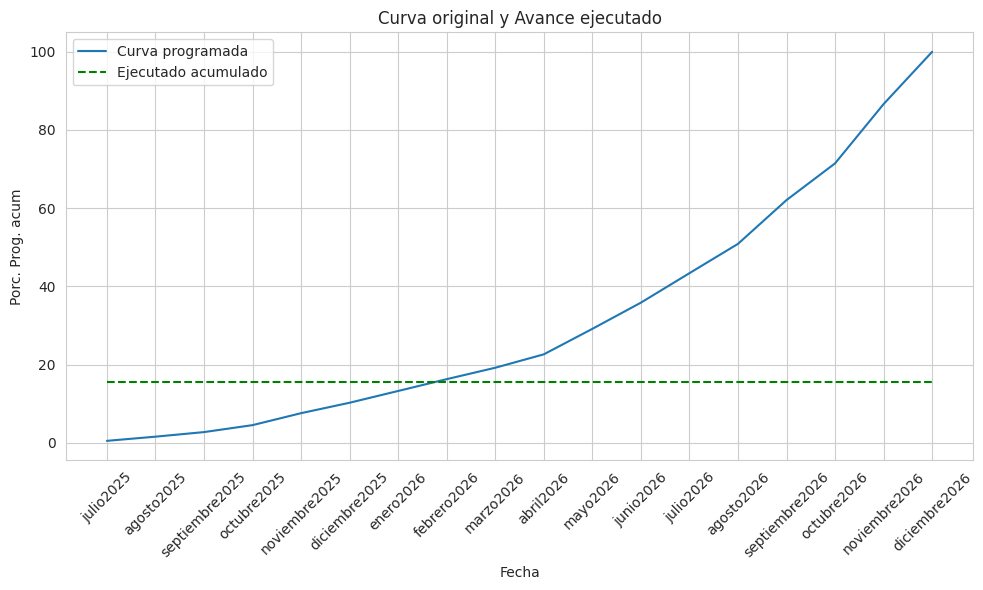

In [15]:
x = df['Mes_Año']
max_ejecutado = df['Porcent. ejec. acum.'].max()
y1 =  df['Porcent. prog. acum.']
y2 = np.full(len(x), max_ejecutado)

plt.figure(figsize=(10, 6)) #tamaño del gráfico

plt.plot(x, y1, label='Curva programada', linestyle='-')
plt.plot(x, y2, label='Ejecutado acumulado', color='green', linestyle='--')


plt.title('Curva original y Avance ejecutado') # titulo
plt.xlabel('Fecha')
plt.ylabel('Porc. Prog. acum')
#plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.savefig('curva_original.png')

plt.show()

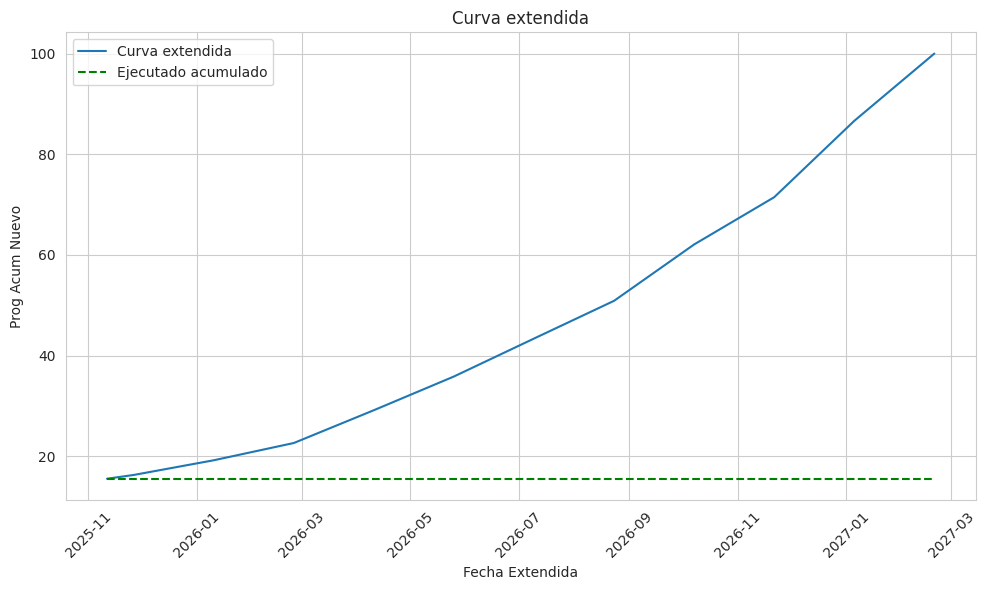

In [16]:

sns.set_style("whitegrid")

x = df_extendido['Fecha_extendida']
max_ejecutado = df['Porcent. ejec. acum.'].max()
y1 =  df_extendido['Prog_acum_nuevo']
y2 = np.full(len(x), max_ejecutado)


plt.figure(figsize=(10, 6)) # Define el tamaño del gráfico

plt.plot(x, y1, label='Curva extendida', linestyle='-')
plt.plot(x, y2, label='Ejecutado acumulado', color='green', linestyle='--')


plt.title('Curva extendida')
plt.xlabel('Fecha Extendida')
plt.ylabel('Prog Acum Nuevo')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('curva_extendida.png')

plt.show()